In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [ ]:
# Define the Lucas-Washburn model parameters
R = 1e-9  # effective pore radius (m)
sigma = 0.072  # surface tension (N/m)
costheta = 0.125
eta = 1e-3  # dynamic viscosity (Pa.s)
b = 17.5 * 1e-9
#C_lucas = 0.00000032* 10**5  # R+4b stuff
#print(C_lucas)
#(sigma costheta /2 eta)(R+4b)t
# 36 cos(theta) * R t + 36 cos(theta) * 4b t
# 36 cos(theta) * R t  + 2.52 * 1e-6 cos(theta) t
theta = np.arccos(costheta)

# Verifying the expressions
factor_36 = (sigma / (2 * eta))*(10 ** 5) * (10**-9)  #putting R in nm directly
print(factor_36)
term_2_52e_6 = (36 * 4 * b)*(10 ** 5)
print(term_2_52e_6)

0.0036000000000000003
0.252


In [ ]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((3,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])

NN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                128       
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2273 (8.88 KB)
Trainable params: 2273 (8.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [ ]:
#Defining the Loss function containing the physics loss and the IC loss:
def lucas_system(R, theta, t, NN):
    global C_lucas, costheta, factor_36, term_2_52e_6
    inputs = np.hstack((R.reshape(-1, 1), theta.reshape(-1, 1), t.reshape(-1, 1)))
    inputs = tf.constant(inputs, dtype=tf.float32)

    t_0 = tf.zeros((1, 1), dtype=tf.float32)
    R_0 = tf.constant([[1]], dtype=tf.float32)
    theta_0 = tf.constant([[np.arccos(costheta)]], dtype=tf.float32)
    h_0 = tf.zeros((1, 1), dtype=tf.float32)

    h_pred = NN(inputs)

    # Physics loss considering the detailed Lucas-Washburn equation
    term1 = factor_36 * costheta * R * t
    term2 = term_2_52e_6 * costheta * t
    physics_loss = h_pred - tf.sqrt(term1 + term2)

    # Initial condition loss
    IC_inputs = tf.concat([R_0, theta_0, t_0], axis=1)
    IC_loss = NN(IC_inputs) - h_0

    loss_sq = tf.square(physics_loss) + tf.square(IC_loss)

    #return tf.reduce_mean(loss_sq) #: for case of not considering experimental losses.

    return loss_sq # consider experimental.

In [ ]:
# add in an experimental loss term, get h from the paper.
data_points = [
    (1, .25),
    (2, .3125),
    (5, .75),
    (8.25, 1.25),
    (10.75, 1.5)
]
# for t, h in data_points:
#   print(t, h)
def exp_loss():
  loss = 0.0
  for t, h in data_points:
    # Calculate the difference between predicted and experimental values
    inputs_exp = tf.constant([[1, np.arccos(0.125), t]], dtype=tf.float32)
    inputs_exp = tf.constant(inputs_exp, dtype=tf.float32)
    h_pred_exp = NN(inputs_exp)
    loss += tf.square(h_pred_exp - h)  # Square the difference
  return loss


In [ ]:
def loss_function(R, theta, t, NN):
  #Physics + IC squared sum:
  loss_1 = lucas_system(R, theta, t, NN)
  #exp loss
  loss_2 = exp_loss()

  loss = tf.reduce_mean(loss_1 + loss_2)
  return loss

In [ ]:
train_t = (np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0])).reshape(-1, 1)
train_t = train_t.astype(np.float32)
train_loss_record = []
R = np.array([1] * len(train_t), dtype=np.float32)  # E12xample input R values
theta = np.array([np.arccos(0.125)] * len(train_t), dtype=np.float32)  # Example input theta values

for itr in range(1000):
  with tf.GradientTape() as tape:

   # train_loss = loss_function(R, theta, train_t, NN)
    train_loss = loss_function(R, theta, train_t, NN)
    train_loss_record.append(train_loss.numpy())

    grad_w = tape.gradient(train_loss, NN.trainable_variables)
    optm.apply_gradients(zip(grad_w, NN.trainable_variables))

  # Print training progress
  if itr % 100 == 0:
    print(train_loss.numpy())

# plt.figure(figsize = (10,8))
# plt.plot(train_loss_record)
# plt.show()


1.5071572
0.38157043
0.33272642
0.31220445
0.30264398
0.29785216
0.29507434
0.29319838
0.29180962
0.29075143


1/1 [==============================] - 0s 40ms/step


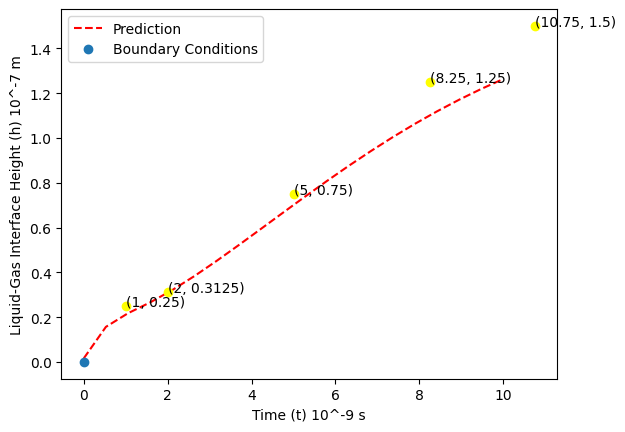

In [ ]:
# Prediction
# Define constants
R_0 = 1  # Example constant R value
theta_0 = np.arccos(0.125)  # Example constant theta value

# Generate test data for varying t
test_t = np.linspace(0, 10, 20).reshape(-1, 1).astype(np.float32)

# Prepare input data with constant R and theta, and varying t
test_inputs = np.hstack([R_0 * np.ones_like(test_t), theta_0 * np.ones_like(test_t), test_t])

# Ensure test_inputs is in float32 format
test_inputs = test_inputs.astype(np.float32)

# Predict heights for the test inputs
pred_h = NN.predict(test_inputs)
# Plot results
plt.plot(test_t, pred_h, '--r', label = 'Prediction')
plt.plot(0, 0, 'o', label='Boundary Conditions')
# plt.plot(test_t, true_h, '-k',label = 'True')
plt.xlabel('Time (t) 10^-9 s')
plt.ylabel('Liquid-Gas Interface Height (h) 10^-7 m')
data_points = [
    (1, .25),
    (2, .3125),
    (5, .75),
    (8.25, 1.25),
    (10.75, 1.5)
]
plt.legend()
for t, h in data_points:
    plt.plot(t, h, 'o', color='yellow')
    plt.annotate(f'({t}, {h})', (t, h))

plt.show()